## Fotoğraflardaki El Yazısı Rakamları Otomatik Tanıma ve Anlamlandırma


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml #mnist datasetini yüklemek için gerekli kütüphane
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784')

In [2]:
mnist.data.shape

(70000, 784)

mnist dataseti içindeki rakam fotoğraflarını görmek için fonksiyon tanımlıyoruz:

In [3]:
def showimage(dframe, index):   #parametreler; dataframe ve ilgili data fotoğrafının indexi
    some_digit = dframe.to_numpy()[index]     # 'to_numpy()' fonksiyonu, pandas veri çerçevesini numpy dizisine dönüştürür. Bu satırda, belirtilen indeksteki veriyi alıp 'some_digit' adlı değişkene atıyoruz.
    some_digit_image = some_digit.reshape(28,28)  # 'reshape' fonksiyonu, veriyi belirtilen boyutlara yeniden şekillendirir. Burada, 28x28 piksellik bir görüntü elde etmek için veriyi yeniden şekillendiriyoruz.


    plt.imshow(some_digit_image, cmap="binary")    # 'imshow' fonksiyonu, görüntüyü ekranda göstermeyi sağlar. 'some_digit_image' adlı görüntüyü 'binary' renk haritasıyla gösteriyoruz.

    plt.axis("off") #Eksenleri kapatıyoruz, böylece çizim üzerindeki eksen işaretleri görünmez.

    plt.show()

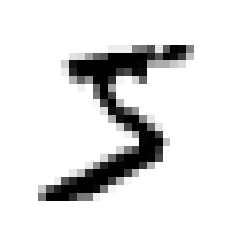

In [6]:
#örnek
showimage(mnist.data, 0)  #mnist datasetindeki ilk data


MNIST veri kümesi, 'mnist.data' ve 'mnist.target' olarak adlandırılan veri ve hedef etiketlerden oluşuyor.

'train_test_split' fonksiyonu, veriyi eğitim ve test altkümelerine ayırmak için kullanılır.

Parametreler:
- 'mnist.data': Veri kümesinin giriş verileri (örneklerin özellikleri)
- 'mnist.target': Veri kümesinin hedef etiketleri (örneklerin doğru sınıfları)
- 'test_size': Test altkümesinin tüm veri kümesine oranı. Bu örnekte 1/7'si (yaklaşık %14.29)
- 'random_state': Rastgele örneklem alma sırasını kontrol etmek için kullanılan rastgele durum değeri

In [7]:
# test oranı: 1/7 , train oranı: 6/7
train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, mnist.target, test_size=1/7.0, random_state=0)

# Yukarıdaki satırda, 'train_test_split' fonksiyonu çağrılır ve dönen sonuçlar sırasıyla dört değişkene atanır:
# - 'train_img': Eğitim verileri (giriş verileri)
# - 'test_img': Test verileri (giriş verileri)
# - 'train_lbl': Eğitim verilerinin hedef etiketleri
# - 'test_lbl': Test verilerinin hedef etiketleri

In [8]:
type(train_img)

pandas.core.frame.DataFrame

In [9]:
# rakam tahminlerini kontrol etmek için değişim öncesi train_img dataframeini kopyalıyoruz
test_img_copy = test_img.copy()

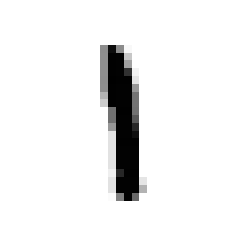

In [10]:
showimage(test_img_copy, 2)

### Scale Aşaması
Scaling: Verilerin farklı ölçeklerde olduğu durumlarda, onları aynı ölçek veya aralığa getirme işlemine verilen isimdir.

PCA, scale edilmemiş verilerde hatalı sonuçlar verebiliyor bu nedenle mutlaka scaling işlemini uyguluyoruz.


In [12]:
scaler = StandardScaler()

scaler.fit(train_img) #scaler işlemini training set üzerinde yapmamız yeterli

#transform işlemi ise hem training hem de test setine yapmamız gerekiyor
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

### PCA İşlemi
Çok değişkenli bir veri setindeki değişkenler arasındaki ilişkileri anlamak ve veri boyutunu azaltmak için kullanılan bir istatistiksel bir tekniktir.


In [13]:
pca = PCA(.95) #variance'ın %95 oranında korunmasını istiyoruz

#PCA modeli, tüm bileşenlerin varyansının %95'ini koruyacak şekilde veriyi sıkıştıracak ve boyut azaltma işlemini gerçekleştirecektir.

In [14]:
pca.fit(train_img) #pca işlemini training sete yapmamız yeterlidir

PCA(n_components=0.95)

In [15]:
print(pca.n_components_) #784 boyutu kaç boyuta düşürdüğüne bakıyoruz

327


In [16]:
#transform işlemiyle train ve test veri setimizin boyutlarını 784'ten 327'ye düşürelim
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

### Logistic Regression Aşaması
Özet olarak Lojistik Regresyon makine öğrenimi ve istatistikte sınıflandırma problemleri için kullanılan bir algoritmadır. İki veya daha fazla sınıf arasında ayrım yapmak amacıyla kullanılır.

Logistic Regression modelimizi PCA işleminden geçirilmiş verisetimiz üzerinde uygulayacağız.

In [17]:
# default solver çok yavaş çalıştığı için daha hızlı olan 'lbfgs' solverı seçerek logisticregression nesnemizi oluşturuyoruz.

logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=10000)

solver='lbfgs': Bu parametre, lojistik regresyon modelinin optimize edilmesi için kullanılacak olan algoritmayı belirtir. 'lbfgs', sınırlı bellekli Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algoritmasını belirtir. Bu algoritma, genellikle lojistik regresyon gibi küçük boyutlu veriler için tercih edilir.

max_iter=10000: Bu parametre, optimizasyon algoritmasının en fazla kaç iterasyon yapacağını belirtir. Burada 10,000 iterasyon kullanıldı. Bu sayı, optimize edilecek modelin karmaşıklığına ve veri boyutuna bağlı olarak ayarlanabilir.

#### LogisticRegression Modelimizi train datamızı kullanarak eğitiyoruz

In [18]:
logisticRegr.fit(train_img, train_lbl)

LogisticRegression(max_iter=10000)

modelimiz eğitildi.
el yazısı rakamları makine öğrenmesi ile tanıma işlemi:

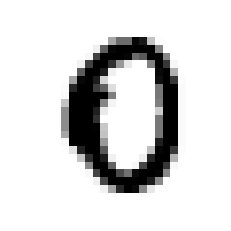

In [20]:
# rakam tahminlerini kontrol etmek için kopya datasetimizden 0. indexin hangi fotoğraf olduğuna bakıyoruz:
showimage(test_img_copy, 0)

In [19]:
# ve makine öğreniminin tahmini:
logisticRegr.predict(test_img[0].reshape(1, -1))

array(['0'], dtype=object)

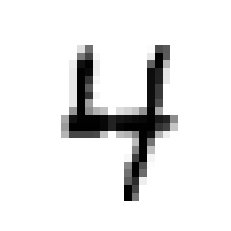

In [21]:
showimage(test_img_copy, 1)

In [23]:
logisticRegr.predict(test_img[1].reshape(1, -1))

array(['4'], dtype=object)

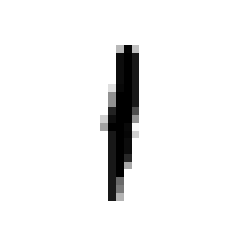

In [25]:
showimage(test_img_copy, 200)

In [26]:
logisticRegr.predict(test_img[200].reshape(1, -1))

array(['1'], dtype=object)

### accuracy score

modelimizin doğruluk oranını ölçelim:

test_img verilerini kullanarak logisticRegr adlı lojistik regresyon modelinin tahminlerini yapar ve ardından bu tahminleri test_lbl (test etiketleri) ile karşılaştırarak doğruluk (accuracy) skorunu hesaplar.

In [27]:
logisticRegr.score(test_img, test_lbl)

0.9184